In [1]:
from pathlib import Path
from dataclasses import dataclass
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from typing import Any

%matplotlib inline
%load_ext autoreload
%autoreload 2


@dataclass
class Config:
    REPO_ROOT: Path = Path("../../")
    data_dir: Path = REPO_ROOT / "data"


config = Config()

sys.path.append(str(config.REPO_ROOT))

In [2]:
from python.src.preprocess import (
    preprocess_bike_data,
)

df_bike = pd.read_csv(config.data_dir / "bike+sharing+dataset" / "day.csv")
df_bike_processed = preprocess_bike_data(df=df_bike)
assert df_bike.shape[0] == df_bike_processed.shape[0]

In [3]:
from python.src.utils import PartialDependence

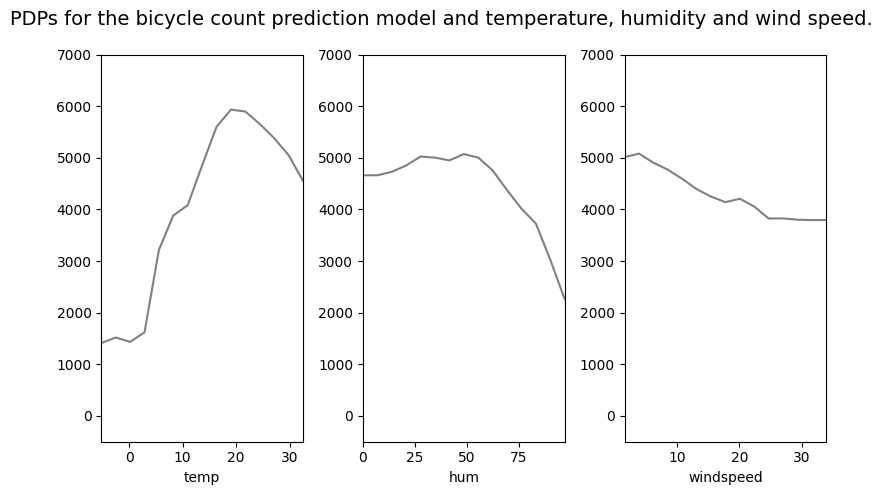

In [4]:
features = ["temp", "hum", "windspeed"]
X = df_bike_processed[features]
y = df_bike_processed["cnt"]
# Train a RandomForestRegressor model
model = RandomForestRegressor(random_state=0)  # random_state for reproducibility
model.fit(X, y)
pdp = PartialDependence(model, X, ["temp", "hum", "windspeed"], pred_type="regression")

fig, axes = plt.subplots(1, 3, figsize=(8, 5))

# Set y-axis limits directly
y_min = -500
y_max = 7000

# Create the PDP plots
for i, (feature, ax) in enumerate(zip(["temp", "hum", "windspeed"], axes.ravel())):
    df_pd = pdp.partial_dependence(feature, n_grid=15)
    x_min, x_max = df_pd[feature].min(), df_pd[feature].max()
    ax.set_ylim(-500, 7000)
    ax.set_xlabel(feature)
    ax.set_xlim(x_min, x_max)
    ax.plot(df_pd[feature], df_pd["avg_pred"], color="gray")

fig.suptitle(
    "PDPs for the bicycle count prediction model and temperature, humidity and wind speed.",
    fontsize=14,
)
plt.tight_layout()
plt.show()

In [5]:
features = ["temp", "hum", "windspeed", "season"]
X = df_bike_processed[features]
X = pd.get_dummies(X, columns=["season"], drop_first=False)
y = df_bike_processed["cnt"]

model = RandomForestRegressor(random_state=0)
model.fit(X, y)

RandomForestRegressor(random_state=0)

In [6]:
pdp = PartialDependence(model, X, X.columns)
pd_dict = {}
for i, feature in enumerate(
    ["season_SPRING", "season_SUMMER", "season_FALL", "season_WINTER"]
):
    df_pd = pdp.partial_dependence(feature, n_grid=15)
    pd_dict[feature] = float(df_pd["avg_pred"].mean())

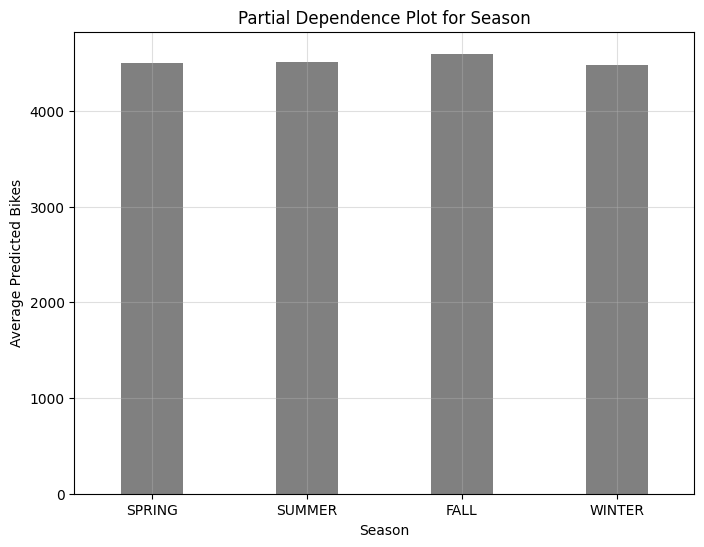

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

x_labels = list(
    [feature.split("_")[1] for feature in pd_dict.keys()]
)  # Extract keys as x-axis labels
y_values = list(pd_dict.values())  # Extract values for y-axis


sns.barplot(x=x_labels, y=y_values, color="gray", ax=ax, width=0.4)

ax.set_xlabel("Season")
ax.set_ylabel("Average Predicted Bikes")
ax.set_title("Partial Dependence Plot for Season")
ax.grid(
    # axis="y",
    linestyle="-",
    alpha=0.4,
)
plt.show()

In [8]:
from python.src.preprocess import (
    preprocess_rfcc,
)

df_rfcc = pd.read_csv(config.data_dir / "risk_factors_cervical_cancer.csv")
df_rfcc_preprocessed = preprocess_rfcc(df=df_rfcc)
assert df_rfcc.shape[0] == df_rfcc_preprocessed.shape[0]

In [9]:
df_rfcc_preprocessed.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Biopsy'],
      dtype='object')

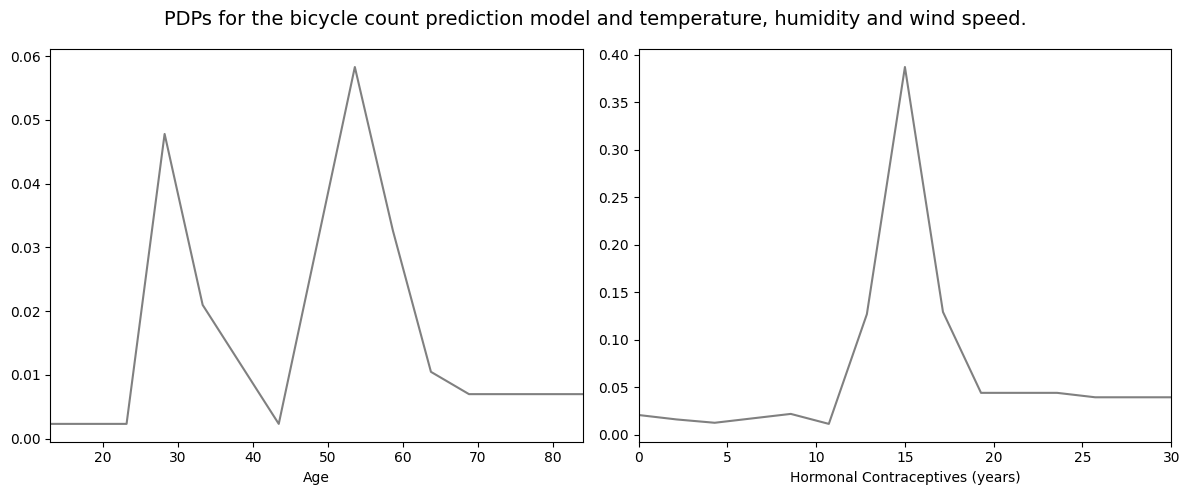

In [10]:
# ---Classification example (cervical cancer)---
faetures = ["Age", "Hormonal Contraceptives (years)", "Num of pregnancies"]
X_cervical = df_rfcc_preprocessed[faetures]
y_cervical = df_rfcc_preprocessed["Biopsy"].map(
    {"Healthy": 0, "Cancer": 1}
)  # Replace with your actual target

model_cervical = RandomForestClassifier(random_state=42)
model_cervical.fit(X_cervical, y_cervical)

pdp = PartialDependence(model_cervical, X_cervical, faetures)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
features_cervical = ["Age", "Hormonal Contraceptives (years)"]

for i, (feature, ax) in enumerate(zip(features_cervical, axes.ravel())):
    df_pd = pdp.partial_dependence(feature, n_grid=15)
    x_min, x_max = df_pd[feature].min(), df_pd[feature].max()
    # ax.set_ylim(-500, 7000)
    ax.set_xlabel(feature)
    ax.set_xlim(x_min, x_max)
    ax.plot(df_pd[feature], df_pd["avg_pred"], color="gray")

fig.suptitle(
    "PDPs for the bicycle count prediction model and temperature, humidity and wind speed.",
    fontsize=14,
)
plt.tight_layout()
plt.show()


In [11]:
df_pd = pdp.partial_dependence("Age", n_grid=15)
df_pd_2 = pdp.partial_dependence("Num of pregnancies", n_grid=15)
combined_df = combined_df = pd.merge(
    df_pd,
    df_pd_2.rename(columns={"avg_pred": "avg_pred_2"}),
    how="cross",  # 全ての組み合わせを作成
)
combined_df["value"] = (combined_df["avg_pred"] + combined_df["avg_pred_2"]) / 2

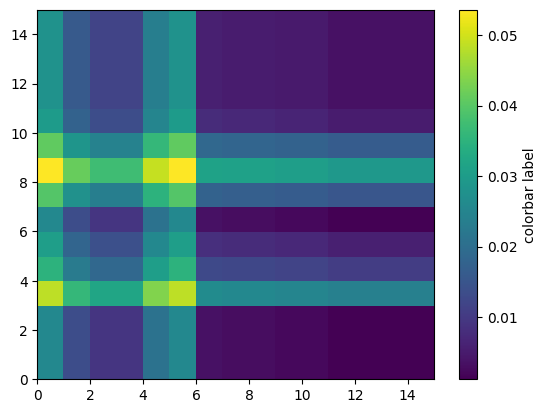

In [12]:
fig, ax = plt.subplots()
c = ax.pcolor(
    np.array(combined_df["value"]).reshape(combined_df["Age"].nunique(), -1),
    # shading="auto",
)
fig.colorbar(
    c,
    ax=ax,
    label="colorbar label",
)
plt.show()